In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()

### Nuclear Accumulating genes, exon length analysis

In [3]:
%%bash
awk '$2== "protein_coding" && $3 == "exon"' \
  /home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/hg19_geneset.gtf | \
  awk -v 'OFS=\t' '{print $1,$4,$5,$12,".",$7,$10,$14}' | \
  sed -e 's/"//g' -e 's/;//g' \
  > /home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/hg19_protein_coding_exons.txt

In [4]:
exons = pd.read_table(
    '/home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/hg19_protein_coding_exons.txt',
    sep='\t',
    names=['chrom', 'start', 'end', 'transcript_id',
           'score', 'strand', 'ensembl_gene_id', 'exon_no'],
    usecols=['chrom', 'start', 'end',
             'transcript_id', 'strand',
             'ensembl_gene_id', 'exon_no'])
exons.head()

,chrom,start,end,transcript_id,strand,ensembl_gene_id,exon_no
0,chr1,69091,70008,ENST00000335137,+,ENSG00000186092,1
1,chr1,137621,139379,ENST00000423372,-,ENSG00000237683,1
2,chr1,134901,135802,ENST00000423372,-,ENSG00000237683,2
3,chr1,367640,368634,ENST00000426406,+,ENSG00000235249,1
4,chr1,621059,622053,ENST00000332831,-,ENSG00000185097,1


In [5]:
nuclear_accum = pd.read_table(
    '/home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/output/nuclear_accumulation_results.tsv',
    sep='\t')
nuclear_accum.head()

,hgnc_symbol,logFC,logCPM,LR,PValue,FDR,description,CC1,CC2,CC3,CN1,CN2,CN3,VWC1,VWC2,VWC3,VWN1,VWN2,VWN3
ENSG00000000003,TSPAN6,-0.233266,4.547133,1.003614,0.316438,0.706286,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],4.215318,4.495514,4.481094,4.954004,5.032120,5.074534,4.132546,3.723161,4.027391,4.487415,4.798596,4.401288
ENSG00000000457,SCYL3,-0.032794,2.643601,0.006032,0.938094,0.985450,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,1.989626,2.688470,2.639699,3.030661,2.792284,2.888040,2.213267,2.135087,2.286395,2.770484,2.933662,2.617338
ENSG00000000460,C1orf112,0.195875,3.533624,0.400316,0.526926,0.835281,chromosome 1 open reading frame 112 [Source:HG...,3.473023,3.967128,3.756768,3.586755,3.629672,3.723973,3.334802,2.883939,3.151964,3.433008,3.645769,3.315958
ENSG00000001036,FUCA2,-0.243525,6.947905,1.550665,0.213037,0.617309,"fucosidase, alpha-L- 2, plasma [Source:HGNC Sy...",5.954524,6.014605,6.074653,7.261143,7.182987,7.169266,6.546289,6.467584,6.456447,7.453878,7.644538,7.634833
ENSG00000001084,GCLC,0.758483,3.600253,6.027932,0.014081,0.199181,"glutamate-cysteine ligase, catalytic subunit [...",3.456407,3.976677,3.986248,3.303358,3.594972,3.579070,3.643707,3.320895,3.270471,3.452879,3.755764,3.467218


In [6]:
nuc_acc_mask = (nuclear_accum.FDR < 0.1) & (nuclear_accum.logFC > 0.5)
nuc_acc_sig = nuclear_accum[nuc_acc_mask]

In [7]:
m6a_cims = pd.read_table(
    '/home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/m6a_cims_gene_overlap.bed',
    sep='\t',
    names=['chrom', 'gene_start', 'gene_end', 'gene_id', 'score',
           'strand', 'chrom2', 'm6a_start', 'm6a_end', 'm6a_info',
           'm6a_score', 'strand2'],
    usecols=['chrom', 'gene_start', 'gene_end', 'gene_id', 'strand',
             'm6a_start', 'm6a_end', 'm6a_score'])
exon_nos = m6a_cims.gene_id.str.split('_', expand=True)
m6a_cims['gene_id'] = exon_nos[0]
m6a_cims['exon_no'] = exon_nos[1].astype('i')
m6a_cims.drop_duplicates(['m6a_start', 'm6a_end', 'gene_id'], inplace=True)
m6a_cims.set_index(['chrom', 'm6a_start', 'm6a_end', 'strand'], inplace=True)
m6a_cims.head()

gene_start  gene_end          gene_id  \
chrom m6a_start m6a_end strand                                          
chr1  566859    566860  +           566454    567996  ENSG00000237973   
      569918    569919  +           569756    570302  ENSG00000198744   
      878150    878151  +           877790    878182  ENSG00000187634   
      879954    879955  -           879584    880180  ENSG00000188976   
      934374    934375  -           934342    934812  ENSG00000188290   

                                m6a_score  exon_no  
chrom m6a_start m6a_end strand                      
chr1  566859    566860  +               2        1  
      569918    569919  +               2        1  
      878150    878151  +               2        2  
      879954    879955  -               2       19  
      934374    934375  -              16        3

In [8]:
m6a_cits = pd.read_table(
    '/home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/m6a_cits_gene_overlap.bed',
    sep='\t',
    names=['chrom', 'gene_start', 'gene_end', 'gene_id', 'score',
           'strand', 'chrom2', 'm6a_start', 'm6a_end', 'm6a_info',
           'm6a_score', 'strand2'],
    usecols=['chrom', 'gene_start', 'gene_end', 'gene_id', 'strand',
             'm6a_start', 'm6a_end', 'm6a_score'])
exon_nos = m6a_cits.gene_id.str.split('_', expand=True)
m6a_cits['gene_id'] = exon_nos[0]
m6a_cits['exon_no'] = exon_nos[1].astype('int')
m6a_cits.drop_duplicates(['m6a_start', 'm6a_end', 'gene_id'], inplace=True)
m6a_cits.set_index(['chrom', 'm6a_start', 'm6a_end', 'strand'], inplace=True)
m6a_cits.head()

gene_start  gene_end          gene_id  \
chrom m6a_start m6a_end strand                                          
chr1  569050    569051  +           568915    569121  ENSG00000240409   
      878150    878151  +           877790    878182  ENSG00000187634   
      878276    878277  +           877939    878374  ENSG00000187634   
      934374    934375  -           934342    934812  ENSG00000188290   
      934422    934423  -           934342    934812  ENSG00000188290   

                                m6a_score  exon_no  
chrom m6a_start m6a_end strand                      
chr1  569050    569051  +               4        1  
      878150    878151  +               4        2  
      878276    878277  +               3        4  
      934374    934375  -              17        3  
      934422    934423  -              13        3

In [9]:
m6a_cims_genes = set(m6a_cims.gene_id)
m6a_cits_genes = set(m6a_cits.gene_id)
nuc_acc = set(nuc_acc_sig.index)
all_m6a_genes = m6a_cims_genes.union(m6a_cits_genes)
m6a_and_nuc_acc = all_m6a_genes.intersection(nuc_acc)
non_m6a_nuc_acc = set(nuclear_accum[~nuclear_accum.index.isin(
    all_m6a_genes.union(nuc_acc))].index)
assert len(non_m6a_nuc_acc.intersection(m6a_and_nuc_acc)) == 0
assert len(non_m6a_nuc_acc.intersection(nuc_acc)) == 0
assert len(non_m6a_nuc_acc.intersection(all_m6a_genes)) == 0

In [10]:
%matplotlib inline


def plot_split_distplot(arr, masks, labels, xlab, ylab='Density', bins='auto',
                        q=(0, 0.95), bw=0.2, gridsize=1000, colours=None, ax=None):
    '''
    Plot two overlaying seaborn distplots from a single array using an array mask
    '''
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    if bins == 'auto':
        bins = np.linspace(arr.quantile(q[0]),
                           arr.quantile(q[1]), 50)
    if colours is None:
        colours = ['b', 'g']
    kde_kws = dict(bw=bw, gridsize=gridsize)
    sns.distplot(arr[masks[1]], bins=bins,
                 label=labels[1], ax=ax,
                 kde_kws=kde_kws, color=colours[1])
    sns.distplot(arr[masks[0]], bins=bins,
                 label=labels[0], ax=ax,
                 kde_kws=kde_kws, color=colours[0])
    ax.set_xlabel(xlab, size=10)
    ax.set_ylabel(ylab, size=10)
    plt.legend(loc=2, fontsize=10)
    return ax

def log_10_scale(ax):
    ax.set_xticklabels(['{:d}'.format(int(x)) for x in 10 ** ax.get_xticks()])

In [11]:
# count the number of exons per transcript
exon_nos = pd.DataFrame(exons.groupby('transcript_id')['exon_no'].max())
exon_nos['ensembl_gene_id'] = exons.groupby('transcript_id')['ensembl_gene_id'].first()
exon_nos.head()

,exon_no,ensembl_gene_id
transcript_id,,
ENST00000000233,6,ENSG00000004059
ENST00000000412,7,ENSG00000003056
ENST00000000442,7,ENSG00000173153
ENST00000001008,10,ENSG00000004478
ENST00000001146,6,ENSG00000003137


Nuclear Accumulating genes have more exons per transcript than most genes

/home/matthew/anaconda3/envs/jupyter_python3/lib/python3.4/site-packages/ipykernel/__main__.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/matthew/anaconda3/envs/jupyter_python3/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


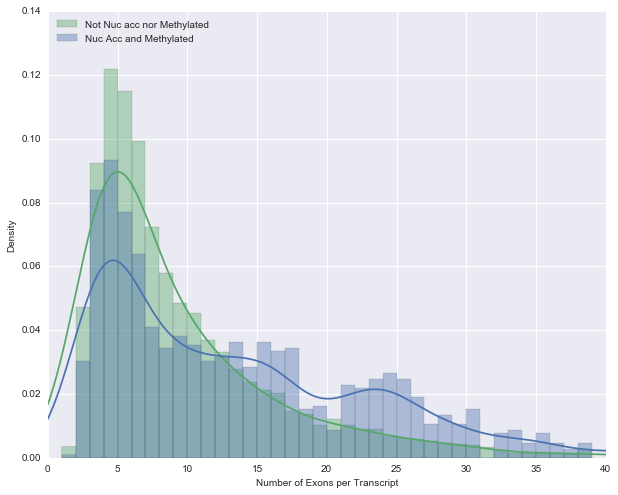

In [19]:
ax = plot_split_distplot(
    exon_nos.exon_no,
    [exon_nos.ensembl_gene_id.isin(m6a_and_nuc_acc),
     exon_nos.ensembl_gene_id.isin(non_m6a_nuc_acc)],
    labels=['Nuc Acc and Methylated', 'Not Nuc acc nor Methylated'],
    xlab='Number of Exons per Transcript',
    bins=np.arange(1, 40),
    bw=2, gridsize=1000,
)
ax.set_xlim(0, 40)
plt.show()

/home/matthew/anaconda3/envs/jupyter_python3/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


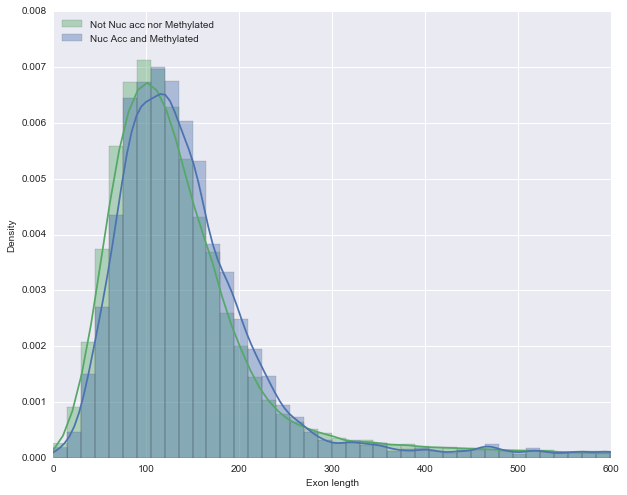

In [20]:
exons['length'] = exons.end - exons.start

ax = plot_split_distplot(
    exons.length,
    [exons.ensembl_gene_id.isin(m6a_and_nuc_acc),
     exons.ensembl_gene_id.isin(non_m6a_nuc_acc)],
    labels=['Nuc Acc and Methylated', 'Not Nuc acc nor Methylated'],
    xlab='Exon length',
    bw=10, gridsize=2000
)
ax.set_xlim(0, 600)
plt.show()

/home/matthew/anaconda3/envs/jupyter_python3/lib/python3.4/site-packages/ipykernel/__main__.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/matthew/anaconda3/envs/jupyter_python3/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


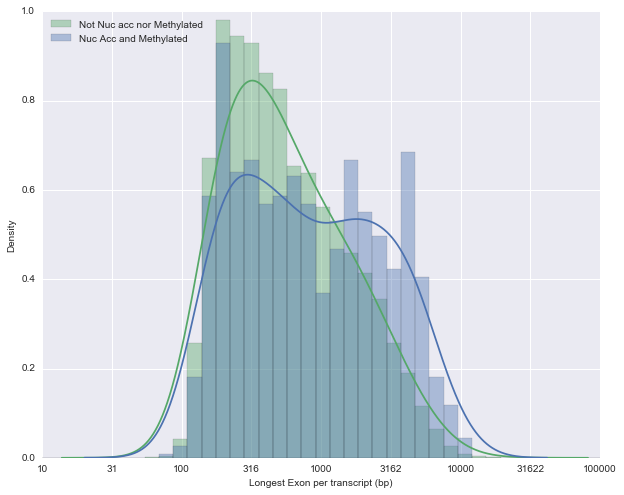

In [21]:
exon_max_transcript = pd.DataFrame(
    exons.groupby('transcript_id')['length'].max())
exon_max_transcript['ensembl_gene_id'] = exons.groupby(
    'transcript_id')['ensembl_gene_id'].first()

ax = plot_split_distplot(
    np.log10(exon_max_transcript.length),
    [exon_max_transcript.ensembl_gene_id.isin(m6a_and_nuc_acc),
     exon_max_transcript.ensembl_gene_id.isin(non_m6a_nuc_acc)],
    labels=['Nuc Acc and Methylated', 'Not Nuc acc nor Methylated'],
    xlab='Longest Exon per transcript (bp)',
    bw=0.2, gridsize=2000, bins=np.linspace(0, 5, 50)
)
ax.set_xlim(1, 5)
log_10_scale(ax)
plt.show()

/home/matthew/anaconda3/envs/jupyter_python3/lib/python3.4/site-packages/ipykernel/__main__.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/matthew/anaconda3/envs/jupyter_python3/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


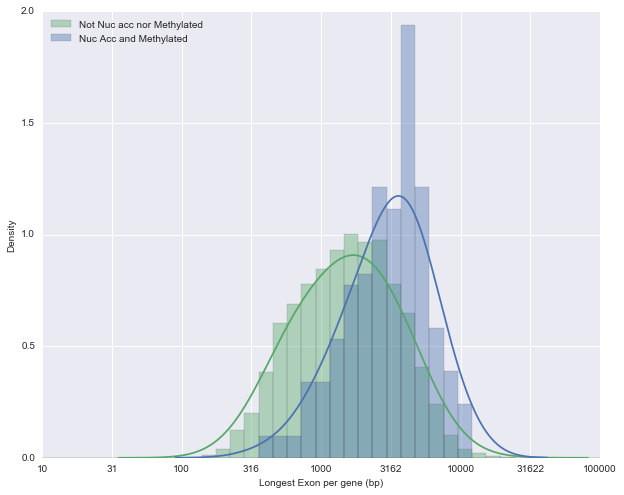

In [22]:
exon_max_gene = pd.DataFrame(
    exon_max_transcript.groupby('ensembl_gene_id')['length'].max())

ax = plot_split_distplot(
    np.log10(exon_max_gene.length),
    [exon_max_gene.index.isin(m6a_and_nuc_acc),
     exon_max_gene.index.isin(non_m6a_nuc_acc)],
    labels=['Nuc Acc and Methylated', 'Not Nuc acc nor Methylated'],
    xlab='Longest Exon per gene (bp)',
    bw=0.2, gridsize=2000, bins=np.linspace(0, 5, 50)
)
ax.set_xlim(1, 5)
log_10_scale(ax)
plt.show()

In [23]:
def label_exons(transcript):
    if len(transcript) > 1:
        label = ['internal'] * len(transcript)
        label[transcript.exon_no.values.argmin()] = 'first'
        label[transcript.exon_no.values.argmax()] = 'last'
        transcript['exon_type'] = label
    else:
        transcript['exon_type'] = ['last']
    return transcript

In [24]:
labeled_exons = exons.groupby('transcript_id').apply(label_exons)
labeled_exons.head()

,chrom,start,end,transcript_id,strand,ensembl_gene_id,exon_no,length,exon_type
0,chr1,69091,70008,ENST00000335137,+,ENSG00000186092,1,917,last
1,chr1,137621,139379,ENST00000423372,-,ENSG00000237683,1,1758,first
2,chr1,134901,135802,ENST00000423372,-,ENSG00000237683,2,901,last
3,chr1,367640,368634,ENST00000426406,+,ENSG00000235249,1,994,last
4,chr1,621059,622053,ENST00000332831,-,ENSG00000185097,1,994,last


In [25]:
final_exons = labeled_exons[labeled_exons.exon_type == 'last']

/home/matthew/anaconda3/envs/jupyter_python3/lib/python3.4/site-packages/ipykernel/__main__.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/matthew/anaconda3/envs/jupyter_python3/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


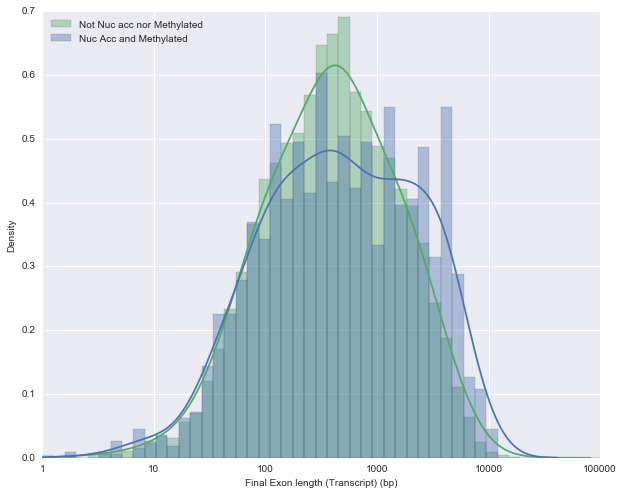

In [26]:
ax = plot_split_distplot(
    np.log10(final_exons.length),
    [final_exons.ensembl_gene_id.isin(m6a_and_nuc_acc),
     final_exons.ensembl_gene_id.isin(non_m6a_nuc_acc)],
    labels=['Nuc Acc and Methylated', 'Not Nuc acc nor Methylated'],
    xlab='Final Exon length (Transcript) (bp)',
    bw=0.2, gridsize=2000, bins=np.linspace(0, 5, 50)
)
ax.set_xlim(0, 5)
log_10_scale(ax)
plt.show()

### Final exon length for increased N/C genes (Fig 3d):

/home/matthew/anaconda3/envs/jupyter_python3/lib/python3.4/site-packages/ipykernel/__main__.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/matthew/anaconda3/envs/jupyter_python3/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


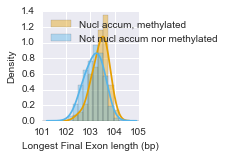

In [27]:
final_exon_max_gene = pd.DataFrame(
    final_exons.groupby('ensembl_gene_id')['length'].max())
fig, ax = plt.subplots(figsize=(2, 2))
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set_style(style)
ax = plot_split_distplot(
    np.log10(final_exon_max_gene.length),
    [final_exon_max_gene.index.isin(non_m6a_nuc_acc),
     final_exon_max_gene.index.isin(m6a_and_nuc_acc)],
    labels=['Not nucl accum nor methylated', 'Nucl accum, methylated'],
    xlab='Longest Final Exon length (bp)',
    bw=0.2, gridsize=2000, bins=np.linspace(0, 5, 25),
    colours=['#56B4E9', '#E69F00'],
    ax=ax
)
ax.set_xlim(1, 5)
ax.set_xticks(np.arange(1, 6))
ax.set_xticklabels(['10{:d}'.format(int(x)) for x in ax.get_xticks()])
plt.tight_layout(pad=0)
plt.savefig('../figures/final_exon_length_per_gene.svg', facecolor='none', transparent=True)
plt.show()